tensor(-1000.) tensor(987.5000)


(np.float64(-0.5), np.float64(2047.5), np.float64(2047.5), np.float64(-0.5))

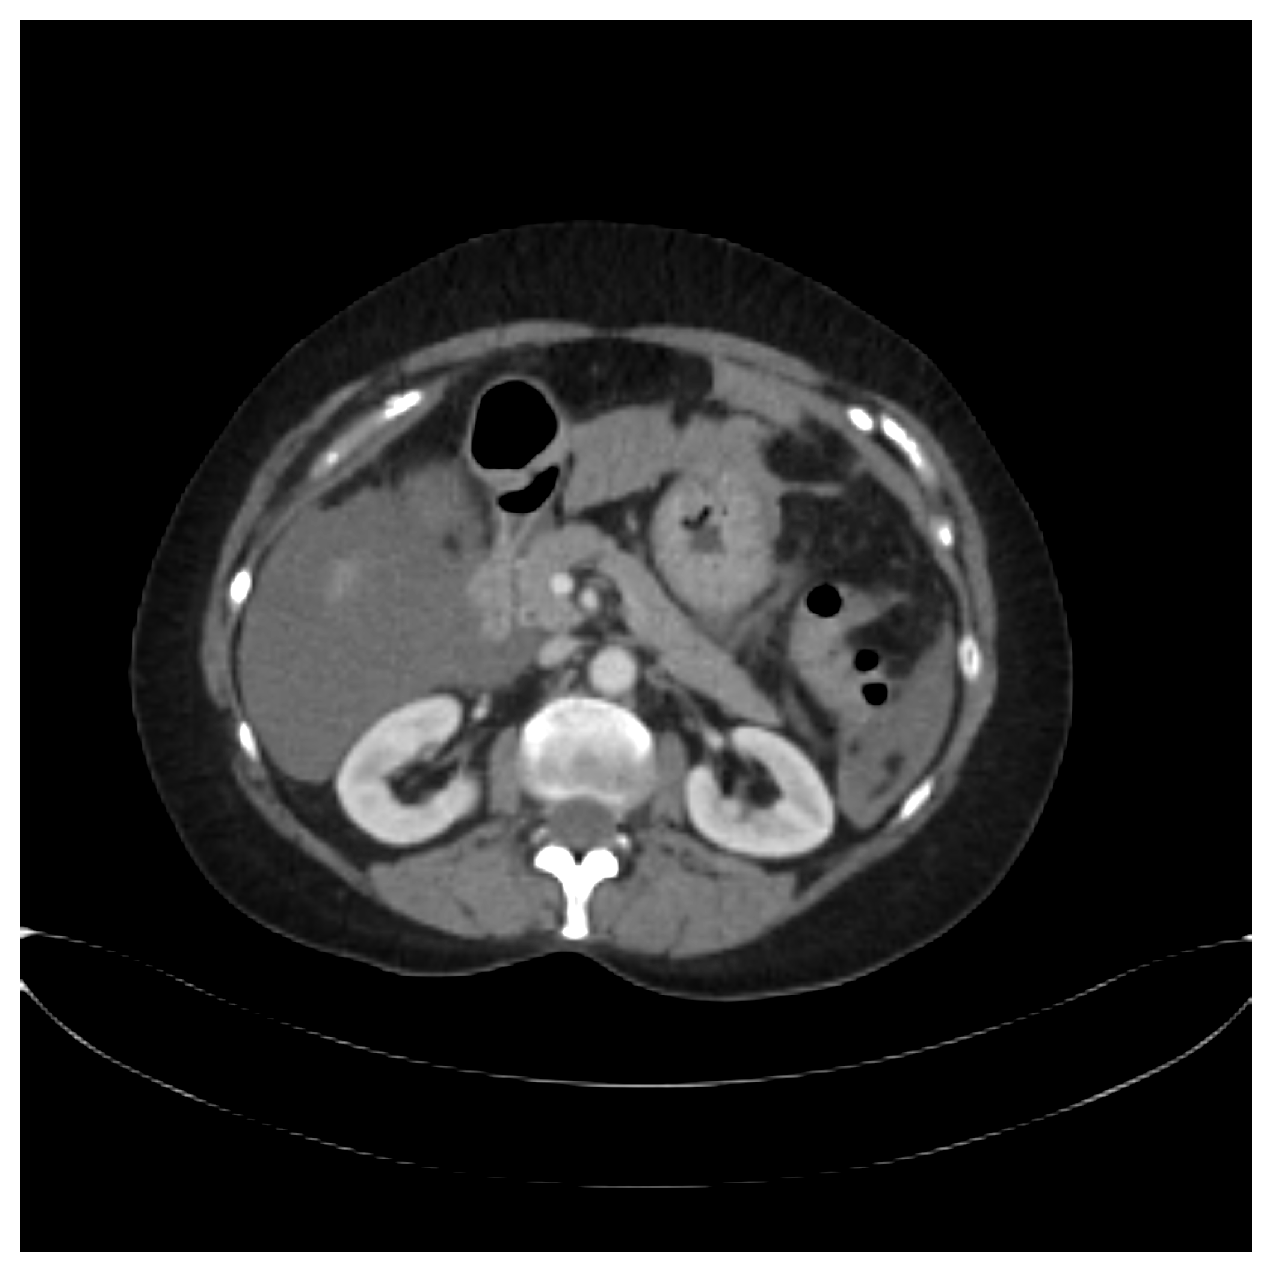

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from sklearn.decomposition import PCA

input_size = 2048
ct_img = torch.Tensor(np.load('/home/yl_li/cleaned_MedDINOv3/MedDINOv3/assets/slice_1866889.npy'))
ct_img = ct_img.unsqueeze(0)

print(ct_img.min(), ct_img.max())
def normalize(img):
    assert img.shape[0] == 1, "Expected shape (1, H, W) for single CT channel."
    img = torch.clamp(img, min=-1000, max=1000)
    mean = 65.1084213256836
    std = 178.01663208007812
    return (img - mean) / (std + 1e-8)

def make_transform(resize_size: int = 224):
    resize = transforms.Resize((resize_size, resize_size), antialias=True)
    return transforms.Compose([resize])

x = normalize(ct_img)
x = x.repeat(3, 1, 1)
resize_transform = make_transform(input_size)
x = resize_transform(x)

plt.figure(figsize=(8,8), dpi=200)
plt.imshow(x[0].numpy(), cmap="gray", vmin=-1.2, vmax=1.2, interpolation="nearest")
plt.axis("off")



In [2]:
import os, sys
from pathlib import Path

try:
    from dotenv import load_dotenv
except Exception:
    load_dotenv = None

# assuming you're running from Med_Dinov3/inference
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
dinov3_parent = os.path.join(
    repo_root, "nnUNet", "nnunetv2", "training", "nnUNetTrainer", "dinov3"
)

for p in (dinov3_parent, repo_root):
    if p not in sys.path:
        sys.path.insert(0, p)

def _find_env_root(start: Path):
    for parent in [start, *start.parents]:
        if (parent / ".env").exists():
            return parent
    return None

env_root = _find_env_root(Path(repo_root))
if load_dotenv and env_root:
    load_dotenv(env_root / ".env", override=False)

from dinov3.models.vision_transformer import vit_base
model = vit_base(drop_path_rate=0.2, layerscale_init=1.0e-05, n_storage_tokens=4, 
                    qkv_bias = False, mask_k_bias= True)

device = torch.device("cuda:0")
chkpt_path = os.getenv(
    "MEDDINOV3_CKPT_PATH",
    "/scr2/yl_li/dinov3/public_release/ct_model_vitb_batch_512_adapt_high_res_4999/model.pth",
)
if env_root and chkpt_path and not os.path.isabs(chkpt_path):
    chkpt_path = str((env_root / chkpt_path).resolve())

chkpt = torch.load(chkpt_path, 
                     weights_only=False, map_location='cpu')
state_dict = chkpt['teacher']
state_dict = {
    k.replace('backbone.', ''): v
    for k, v in state_dict.items()
    if 'ibot' not in k and 'dino_head' not in k
}
model.load_state_dict(state_dict)
model.to(device)
model.eval()



DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (rope_embed): RopePositionEmbedding()
  (blocks): ModuleList(
    (0-11): 12 x SelfAttentionBlock(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): SelfAttention(
        (qkv): LinearKMaskedBias(in_features=768, out_features=2304, bias=False)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
    )
  )
  (norm): Layer

In [3]:
def visualize_pca(sample, model, input_size):
    print(sample.shape)
    norm_sample = (sample - torch.min(sample)) / (torch.max(sample)- torch.min(sample))
    print(torch.min(sample), torch.max(sample))

    with torch.no_grad():
        features = model(sample.unsqueeze(0).to(device), is_training=True)['x_norm_patchtokens']

    pca = PCA(n_components=3, whiten=True)
    pca_features = pca.fit_transform(features.squeeze(0).cpu().detach().numpy()) # [input_size*input_size, 3]

    # put pca features into 0-1 scale
    norm_pca_feats = (pca_features - pca_features.min()) / (pca_features.max() - pca_features.min())
    norm_pca_feats = norm_pca_feats.reshape(input_size//model.patch_size, input_size//model.patch_size, -1)

    # Create one figure with 2 subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))  # (rows=1, cols=2), adjust figsize for bigger plot

    # First subplot: CT image
    axes[0].imshow(np.transpose(norm_sample.numpy(), (1,2,0)), cmap="gray")
    axes[0].axis('off')
    axes[0].set_title("CT image")

    # Second subplot: PCA features
    axes[1].imshow(norm_pca_feats)
    axes[1].axis('off')
    axes[1].set_title("PCA Features")

    plt.tight_layout()
    plt.show()

torch.Size([3, 2048, 2048])
tensor(-5.9832) tensor(5.1434)


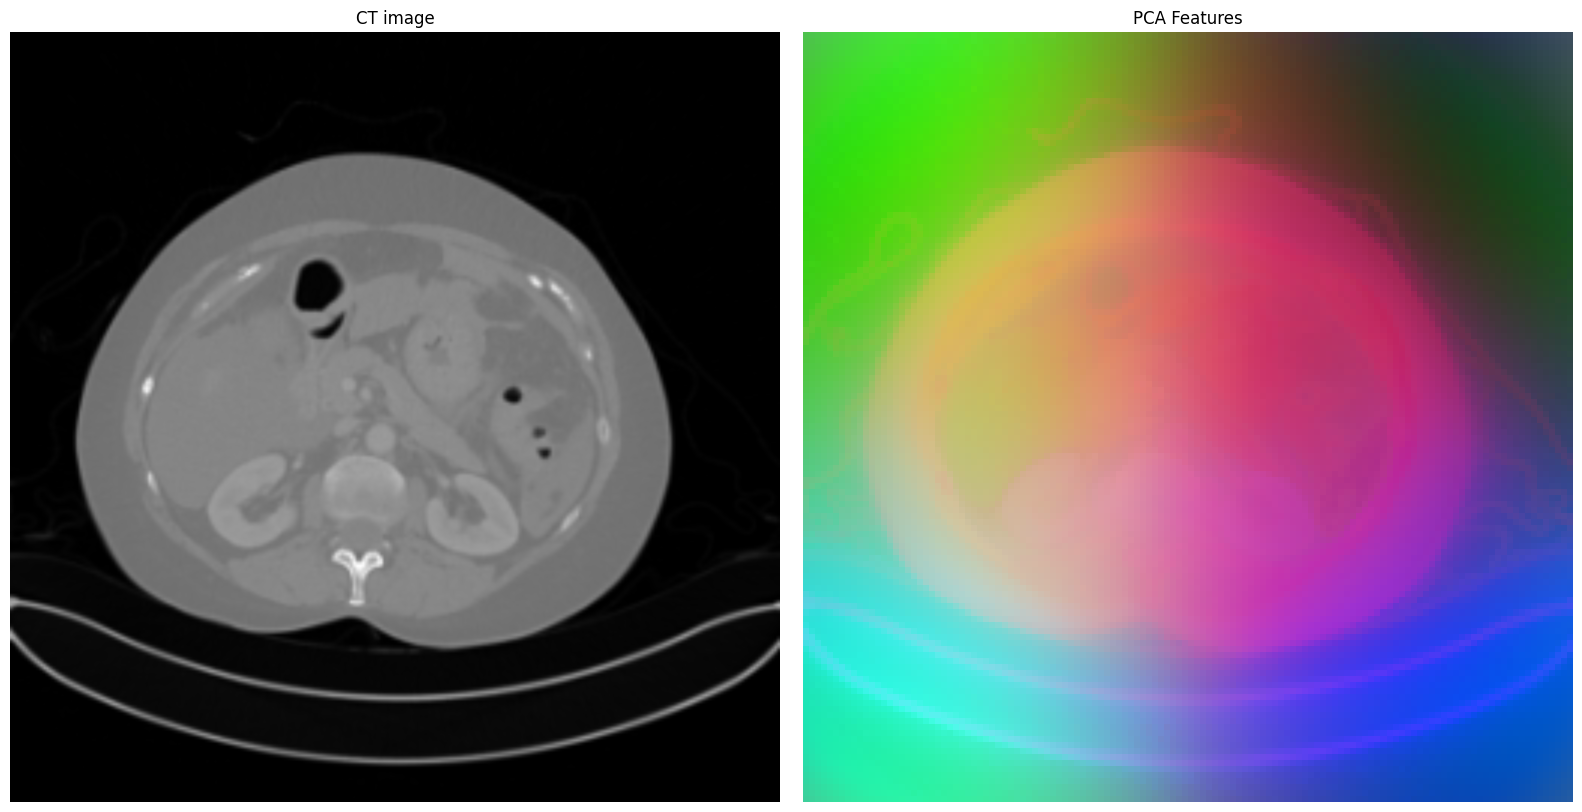

In [4]:
visualize_pca(x, model, input_size)